In [56]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
from scipy.interpolate import interp2d
import os
import sys
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate
import h5py
from auxiliary_merge import m_DateList


def dist2coast_cal(filedist2coast, xynew):
    d = np.load(filedist2coast)
    latdist = d['latdist']
    londist = d['londist']
    dist2coast = d['dist2coast']
    xynew[xynew[:, 0] < np.min(latdist), 0] = np.min(latdist)
    xynew[xynew[:, 0] > np.max(latdist), 0] = np.max(latdist)
    xynew[xynew[:, 1] < np.min(londist), 1] = np.min(londist)
    xynew[xynew[:, 1] > np.max(londist), 1] = np.max(londist)

    latdist = np.flipud(latdist)  # ascending latitude
    dist2coast = np.flipud(dist2coast)
    rg = RegularGridInterpolator((latdist, londist), dist2coast, method='linear')
    distnew = rg(xynew)
    return distnew

def demread(file, lattar, lontar):
    datatemp = io.loadmat(file)
    demori = datatemp['DEM']
    ratio = datatemp['pixelratio']
    demori[ratio<0.5] = 0
    demori[np.isnan(demori)] = 0
    info = datatemp['Info'][0][0]
    latori = np.arange(info['yll'] + info['Ysize'] * info['nrows'] - info['Ysize'] / 2, info['yll'], -info['Ysize'])
    lonori = np.arange(info['xll'] + info['Xsize'] / 2, info['xll'] + info['Xsize'] * info['ncols'], info['Xsize'])
    f = interp2d(lonori, latori, demori, kind='linear')
    demtar = f(lontar.flatten(), lattar.flatten())
    demtar = np.flipud(demtar)
    return demtar


def neargrid(rowtar, coltar, rowori, colori, hwsize):
    # inputs are 1D matrices
    # tar is target area
    # ori is original area
    # hwsize is half window size (e.g., 4 means the space window width/length is 2*4+1)
    # find a space window centering the target grid in the original area and calculate the weights
    nrows = len(rowtar)
    ncols = len(coltar)
    rowse = np.zeros([nrows, ncols, 2]).astype(int)  # se: start/end
    colse = np.zeros([nrows, ncols, 2]).astype(int)  # se: start/end
    weight = np.nan * np.zeros([nrows, ncols, (hwsize * 2 + 1) ** 2])  # from left to right/from top to bottom weight

    for rr in range(nrows):
        rowloc = np.argmin(np.abs(rowori - rowtar[rr]))
        rowse[rr, :, 0] = rowloc - hwsize
        rowse[rr, :, 1] = rowloc + hwsize

    for cc in range(ncols):
        colloc = np.argmin(np.abs(colori - coltar[cc]))
        colse[:, cc, 0] = colloc - hwsize
        colse[:, cc, 1] = colloc + hwsize

    rowse[rowse < 0] = 0
    rowse[rowse > nrows] = nrows
    colse[colse < 0] = 0
    colse[colse > ncols] = nrows

    maxdist = (hwsize + 0.5) * np.sqrt(2) + 0.5
    for rr in range(nrows):
        rowloc = np.argmin(np.abs(rowori - rowtar[rr]))
        for cc in range(ncols):
            colloc = np.argmin(np.abs(colori - coltar[cc]))

            rowse_rc = rowse[rr, cc, :]
            colse_rc = colse[rr, cc, :]
            flag = 0
            for i in range(rowse_rc[0], rowse_rc[1] + 1):
                for j in range(colse_rc[0], colse_rc[1] + 1):
                    dist = ((rowloc - i) ** 2 + (colloc - j) ** 2) ** 0.5
                    weight[rr, cc, flag] = au.distanceweight(dist, maxdist, 3)
                    flag = flag + 1

            weight[rr, cc, :] = weight[rr, cc, :] / np.nansum(weight[rr, cc, :])

    return rowse, colse, weight


def readownscale(dataori, latori, lonori, demori, lattar, lontar, demtar, rowse, colse, weight, mask):
    nrows = len(lattar)
    ncols = len(lontar)
    ntimes = np.shape(dataori)[2]
    lonori, latori = np.meshgrid(lonori, latori)
    datatar = np.nan * np.zeros([nrows, ncols, ntimes])

    for rr in range(nrows):
        for cc in range(ncols):
            if mask[rr, cc] == 1:
                rloc = rowse[rr, cc, :]
                cloc = colse[rr, cc, :]
                latnear = latori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
                lonnear = lonori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
                demnear = demori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
                nnum = np.size(latnear)
                latnear = np.reshape(latnear, nnum)
                lonnear = np.reshape(lonnear, nnum)
                demnear = np.reshape(demnear, nnum)
                weightnear = np.zeros([nnum, nnum])
                for i in range(nnum):
                    weightnear[i, i] = weight[rr, cc, i]

                nearinfo = np.zeros([nnum, 4])
                nearinfo[:, 0] = 1
                nearinfo[:, 1] = latnear
                nearinfo[:, 2] = lonnear
                nearinfo[:, 3] = demnear

                tarinfo = np.zeros(4)
                tarinfo[0] = 1
                tarinfo[1] = lattar[rr]
                tarinfo[2] = lontar[cc]
                tarinfo[3] = demtar[rr, cc]

                tx_red = np.transpose(nearinfo)
                twx_red = np.matmul(tx_red, weightnear)

                for tt in range(ntimes):
                    datanear = dataori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1, tt]
                    datanear = np.reshape(datanear, nnum)

                    # upper and lower boundary for the downscaled data
                    # this is a conservative limitation
                    lowbound = np.min(datanear)
                    upbound = np.max(datanear)
                    if np.sign(lowbound) == 1:
                        lowbound = lowbound * 0.8
                    else:
                        lowbound = lowbound * 1.2
                    if np.sign(upbound) == 1:
                        upbound = upbound * 1.2
                    else:
                        upbound = upbound * 0.8

                    b = reg.least_squares(nearinfo, datanear, twx_red)
                    datatemp = np.dot(tarinfo, b)
                    if np.all(b == 0) or datatemp > upbound or datatemp < lowbound or np.isnan(datatemp):
                        # use nearest neighbor interpolation
                        weightnear = weight[rr, cc, 0:nnum]
                        mloc = np.argmax(weightnear)
                        datatar[rr, cc, tt] = datanear[mloc]
                    else:
                        datatar[rr, cc, tt] = datatemp
    return datatar


def readownscale_tostn(dataori, latori, lonori, demori, dist2coast_ori, rowse, colse, weight, stn_row, stn_col,
                       data0, method, stn_lle, dist2coast_stn, tlr):
    nstn = len(stn_row)
    ntimes = np.shape(dataori)[2]
    datatar = np.nan * np.zeros([nstn, ntimes], dtype=np.float32)

    if method == 'linear' or method == 'nearest':
        xynew = stn_lle[:,[0, 1]]
        latori = np.flipud(latori) # ascending latitude
        dataori = np.flipud(dataori)
        for i in range(ntimes):
            # print('Time step:',i,ntimes)
            rg = RegularGridInterpolator((latori, lonori), dataori[:, :, i], method=method)
            datatar[:, i] = rg(xynew)

    elif method == 'GWR':
        lonori, latori = np.meshgrid(lonori, latori)
        for gg in range(3084,3084+1):
            if np.mod(gg, 5000) == 0:
                print('station', gg, nstn)

            if np.isnan(data0[gg]):
                continue  # station does not have observations, thus does not need downscaling

            rr = stn_row[gg]
            cc = stn_col[gg]
            rloc = rowse[rr, cc, :]
            cloc = colse[rr, cc, :]
#             rloc[0]=rloc[0]+1
#             rloc[1]=rloc[1]-1
#             cloc[0]=cloc[0]+1
#             cloc[1]=cloc[1]-1
            latnear = latori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
            lonnear = lonori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
            demnear = demori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
            distnear = dist2coast_ori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
            nnum = np.size(latnear)
            latnear = np.reshape(latnear, nnum)
            lonnear = np.reshape(lonnear, nnum)
            demnear = np.reshape(demnear, nnum)
            distnear = np.reshape(distnear, nnum)
            weightnear = np.zeros([nnum, nnum])
            for i in range(nnum):
                weightnear[i, i] = weight[rr, cc, i]

            nearinfo = np.zeros([nnum, 5])
            nearinfo[:, 0] = 1
            nearinfo[:, 1] = latnear
            nearinfo[:, 2] = lonnear
            nearinfo[:, 3] = demnear
            nearinfo[:, 4] = distnear
            indland = demnear != 0
            nearinfo=nearinfo[indland,:]
            weightnear=weightnear[indland,:]
            weightnear=weightnear[:,indland]
            nnum=np.sum(indland)
#             nearinfo=nearinfo[:,[0,1,2,4]]

            tarinfo = np.zeros(5)
            tarinfo[0] = 1
            tarinfo[1] = stn_lle[gg, 0]
            tarinfo[2] = stn_lle[gg, 1]
            tarinfo[3] = stn_lle[gg, 2]
            tarinfo[4] = dist2coast_stn[gg]
#             tarinfo=tarinfo[[0,1,2,4]]

            tx_red = np.transpose(nearinfo)
            twx_red = np.matmul(tx_red, weightnear)

            for tt in range(ntimes):
                datanear = dataori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1, tt]
                datanear = np.reshape(datanear, np.size(datanear))
                datanear = datanear[indland]

                # upper and lower boundary for the downscaled data
                # this is a conservative limitation
                lowbound = np.min(datanear)
                upbound = np.max(datanear)
                if np.sign(lowbound) == 1:
                    lowbound = lowbound * 0.8
                else:
                    lowbound = lowbound * 1.2
                if np.sign(upbound) == 1:
                    upbound = upbound * 1.2
                else:
                    upbound = upbound * 0.8

                b = reg.least_squares(nearinfo, datanear, twx_red)
                datatemp = np.dot(tarinfo, b)
                if np.all(b == 0) or datatemp > upbound or datatemp < lowbound or np.isnan(datatemp):
                    # use nearest neighbor interpolation
                    weightneartt = weight[rr, cc, 0:nnum]
                    mloc = np.argmax(weightneartt)
                    datatar[gg, tt] = datanear[mloc]
                else:
                    datatar[gg, tt] = datatemp

    elif method == 'TLR':
        # tlr = -6.5
        # downscale original data to sea level
        demori2 = demori[:,:,np.newaxis] / 1000
        demori2 = np.tile(demori2,[1,1,ntimes])
        dataori = dataori - demori2 * tlr
        for i in range(nstn):
            rowi = np.argmin(abs(stn_lle[i,0] - latori))
            coli = np.argmin(abs(stn_lle[i, 1] - lonori))
            tlri = tlr[rowi, coli, :]
            dataorii = dataori[rowi, coli, :]
            datatar[i, :] = dataorii + stn_lle[i, 2] / 1000 * tlri
    else:
        sys.exit('Unknown downscaling method')
    return datatar


def readstndata(inpath, stnID, ndays):
    nstn = len(stnID)
    prcp_stn = np.nan * np.zeros([nstn, ndays])
    tmin_stn = np.nan * np.zeros([nstn, ndays])
    tmax_stn = np.nan * np.zeros([nstn, ndays])

    for i in range(nstn):
        if np.mod(i, 1000) == 0:
            print('station', i, nstn)
        file = inpath + '/' + stnID[i] + '.nc'
        fid = nc.Dataset(file)
        varlist = fid.variables.keys()
        if 'prcp' in varlist:
            prcp_stn[i, :] = fid['prcp'][:].data
        if 'tmin' in varlist:
            tmin_stn[i, :] = fid['tmin'][:].data
        if 'tmax' in varlist:
            tmax_stn[i, :] = fid['tmax'][:].data
        fid.close()

    tmean_stn = (tmin_stn + tmax_stn) / 2
    trange_stn = np.abs(tmax_stn - tmin_stn)

    return prcp_stn, tmean_stn, trange_stn


########################################################################################################################

# time periods: inside or outside
# outside
# a = int(sys.argv[1])
# b = int(sys.argv[2])
# downtostn_method = sys.argv[3]
# year = [a, b]
# inside
year = [2018, 2018]
print('start/end year', year)
# print('downtostn_method', downtostn_method)

########################################################################################################################

vars = ['prcp', 'tmin', 'tmax']
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)
hwsize = 2  # use (2*2+1)**2 grids to perform regression
downtostn_method = 'GWR' # method choices: "GWR", "nearest", "linear", "TLR"

# basic information: be set before running
# mac
filedem = './DEM/NA_DEM_010deg_trim.mat'
# plato
# filedem = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'

# station information
# mac
gmet_stnfile = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt'
gmet_stnpath = '/Users/localuser/GMET/StnInput_daily'
gmet_stndatafile = '/Users/localuser/Research/EMDNA/stndata_whole.npz' # to be saved. only process when absent
# plato
# gmet_stnfile = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stnpath = '/home/gut428/GMET/StnInput_daily'
# gmet_stndatafile = '/home/gut428/stndata_whole.npz'  # to be saved. only process when absent

# reanalysis path: ERA-5
# mac
filedem_era = './DEM/MERRA2_DEM2.mat'
inpath = '/Users/localuser/Research/EMDNA/downscale/MERRA2'
outpath = '/Users/localuser/Research/EMDNA/downscale/MERRA2'
# plato
# filedem_era = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/MERRA2_DEM2.mat'
# inpath = '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_raw'  # downscale to 0.1 degree
# outpath = '/home/gut428'
file_readownstn = outpath + '/MERRA2_downto_stn_' + downtostn_method + '.npz'  # downscale to station points (1979-2018)
# filenear = '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_ds/weight_dem.npz'
filenear = '/Users/localuser/Research/EMDNA/downscale/MERRA2/weight_dem.npz'

filedist2coast = '/Users/localuser/Research/EMDNA/dist2coast_001.npz'
filetlr = '/Users/localuser/Research/EMDNA/MERRA2_TLR.mat'


start/end year [2018, 2018]


In [2]:
########################################################################################################################

# read some basic infomation
datatemp = io.loadmat(filedem)
demtar = datatemp['DEM']  # this is consistent with lontar lattar
mask = demtar.copy()
mask[~np.isnan(mask)] = 1

stn_ID = np.genfromtxt(gmet_stnfile, dtype='str', skip_header=1, comments='#', delimiter=',', usecols=(0), unpack=False)
stn_lle = np.loadtxt(gmet_stnfile, dtype=float, skiprows=1, comments='#', delimiter=',', usecols=(1, 2, 3),
                     unpack=False)
stn_row = ((85 - stn_lle[:, 0]) / 0.1).astype(int)
stn_col = ((stn_lle[:, 1] + 180) / 0.1).astype(int)
nstn = len(stn_ID)
ndays = 14610  # days from 1979 to 2018

# read all station data and save to facilitate analysis in the future
if not os.path.isfile(gmet_stndatafile):
    prcp_stn, tmean_stn, trange_stn = readstndata(gmet_stnpath, stn_ID, ndays)
    prcp_stn = np.float32(prcp_stn)
    tmean_stn = np.float32(tmean_stn)
    trange_stn = np.float32(trange_stn)
    np.savez_compressed(gmet_stndatafile, prcp_stn=prcp_stn, tmean_stn=tmean_stn, trange_stn=trange_stn,
                        stn_ID=stn_ID, stn_lle=stn_lle, stn_row=stn_row, stn_col=stn_col)

# date
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

# calculate distance to coast from a 0.04 degree map using interpolation
dist2coast_stn = dist2coast_cal(filedist2coast,  stn_lle[:, [0,1]])


# load tlr
infile = inpath + '/MERRA2_prcp_2018.mat'
datatemp = {}
f = h5py.File(infile, 'r')
for k, v in f.items():
    datatemp[k] = np.array(v)
latori = datatemp['latitude'][0]
lonori = datatemp['longitude'][0]

dt = io.loadmat(filetlr)
TLRori=dt['TLRori']
latM0=dt['latM0']
lonM0=dt['lonM0']

TLRnew = np.nan * np.zeros([len(latori),len(lonori), np.shape(TLRori)[2]])
for i in range(np.shape(TLRori)[2]):
    f = interpolate.interp2d(latM0, lonM0, TLRori[:,:,0], kind='linear')
    tlrnew = f(latori, lonori)
    tlrnew = np.flipud(tlrnew.T)
    TLRnew[:,:,i] = tlrnew
TLRuse = np.nan * np.zeros([len(latori),len(lonori), 12])
for i in range(12):
    TLRuse[:,:,i] = np.nanmean(TLRnew[:,:,np.arange(i,np.shape(TLRori)[2], 12)],axis=2)

# distance to coast
lonorim, latorim = np.meshgrid(lonori, latori)
xynew = np.vstack((latorim.flatten(),lonorim.flatten())).T
dist2coast_ori = dist2coast_cal(filedist2coast,  xynew)
dist2coast_ori = np.reshape(dist2coast_ori,np.shape(latorim))

In [47]:
datatemp = np.load(gmet_stndatafile)
prcp_stn0 = datatemp['prcp_stn'][:, 0]
tmean_stn0 = datatemp['tmean_stn'][:, 0]
del datatemp

if not os.path.isfile(file_readownstn):

    prcp_readown = np.float32(np.nan * np.zeros([nstn, ndays]))
    tmean_readown = np.float32(np.nan * np.zeros([nstn, ndays]))
    trange_readown = np.float32(np.nan * np.zeros([nstn, ndays]))

    # load nearby grid information
    datatemp = io.loadmat(filenear)
    rowse = datatemp['rowse']
    colse = datatemp['colse']
    weight = datatemp['weight']
    demori = datatemp['demori']

    for y in range(year[0], year[1]+1):
        indy = date_number['yyyy'] == y
        print('Downscale to station: year', y)
        # produce TLR matrix for this year
        if downtostn_method == 'TLR':
            TLRy = np.zeros([np.shape(TLRuse)[0], np.shape(TLRuse)[1], np.sum(indy)])
            mmy = date_number['mm'][indy]
            for i in range(np.sum(indy)):
                TLRy[:,:,i] = TLRuse[:,:,mmy[i]-1]
        else:
            TLRy = -6.5

        # prcp downscaling
        infile = inpath + '/MERRA2_prcp_' + str(y) + '.mat'
        file_readownstny = outpath + '/MERRA2_downto_stn_' + downtostn_method + str(y) + '.npz'

        if not os.path.isfile(infile):
            print('infile does not exist')
            continue

        if os.path.isfile(file_readownstny):
            print('file exists. loading')
            datatemp = np.load(file_readownstny)
            prcptar=datatemp['prcptar']
            tmintar = datatemp['tmintar']
            tmaxtar = datatemp['tmaxtar']
        else:
            datatemp = {}
            f = h5py.File(infile, 'r')
            for k, v in f.items():
                datatemp[k] = np.array(v)
            latori = datatemp['latitude'][0]
            lonori = datatemp['longitude'][0]
            dataori = datatemp['data']
            dataori = np.transpose(dataori, [2, 1, 0])
            del datatemp
            f.close()
            if downtostn_method == 'TLR':
                prcptar = readownscale_tostn(dataori, latori, lonori, demori, dist2coast_ori, rowse, colse, weight,
                                             stn_row, stn_col, prcp_stn0, 'nearest', stn_lle, dist2coast_stn, TLRy)
            else:
                prcptar = readownscale_tostn(dataori, latori, lonori, demori, dist2coast_ori, rowse, colse, weight,
                                             stn_row, stn_col, prcp_stn0, downtostn_method, stn_lle, dist2coast_stn, TLRy)

            # tmin downscaling
            infile = inpath + '/MERRA2_tmin_' + str(y) + '.mat'
            datatemp = {}
            f = h5py.File(infile, 'r')
            for k, v in f.items():
                datatemp[k] = np.array(v)
            latori = datatemp['latitude'][0]
            lonori = datatemp['longitude'][0]
            dataori = datatemp['data']
            dataori = np.transpose(dataori, [2, 1, 0])
            del datatemp
            f.close()
            tmintar = readownscale_tostn(dataori, latori, lonori, demori, dist2coast_ori, rowse, colse, weight,
                                         stn_row, stn_col, tmean_stn0, downtostn_method, stn_lle, dist2coast_stn, TLRy)

            # tmax downscaling
            infile = inpath + '/MERRA2_tmax_' + str(y) + '.mat'
            datatemp = {}
            f = h5py.File(infile, 'r')
            for k, v in f.items():
                datatemp[k] = np.array(v)
            latori = datatemp['latitude'][0]
            lonori = datatemp['longitude'][0]
            dataori = datatemp['data']
            dataori = np.transpose(dataori, [2, 1, 0])
            del datatemp
            f.close()
            tmaxtar = readownscale_tostn(dataori, latori, lonori, demori, dist2coast_ori, rowse, colse, weight,
                                         stn_row, stn_col, tmean_stn0, downtostn_method, stn_lle, dist2coast_stn, TLRy)

#             np.savez_compressed(file_readownstny, prcptar=prcptar, tmintar=tmintar, tmaxtar=tmaxtar)

        # merge
        prcp_readown[:, indy] = prcptar
        tmean_readown[:, indy] = (tmintar + tmaxtar) / 2
        trange_readown[:, indy] = np.abs(tmaxtar - tmintar)

#     np.savez_compressed(file_readownstn, prcp_readown=prcp_readown, tmean_readown=tmean_readown,
#                         trange_readown=trange_readown,
#                         latitude=lattar, longitude=lontar, stn_ID=stn_ID, stn_lle=stn_lle, stn_row=stn_row,
#                         stn_col=stn_col)

Downscale to station: year 2018


In [8]:
# datatemp = np.load(gmet_stndatafile)
# trange_stn = datatemp['trange_stn']

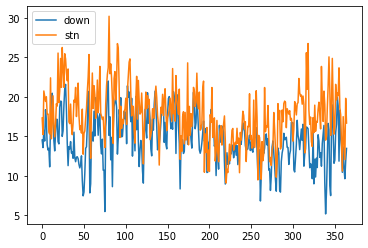

In [48]:
plt.plot(trange_readown[3084, indy])
plt.plot(trange_stn[3084, indy])
plt.legend(['down','stn'])

In [59]:
            demori = demread(filedem_era, latori, lonori)
            io.savemat(filenear, {'rowse': rowse, 'colse': colse, 'weight': weight, 'demori': demori})